In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob

# Folder path containing match CSV files
folder_path = "/Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/"
output_file = "WSL xT.xlsx"

# Import xT Grid
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

# List all CSV files in the folder
csv_files = glob(os.path.join(folder_path, "*.csv"))

# Initialize empty list to store data from all matches
all_data = []

for file in csv_files:
    try:
        # Read CSV file
        df = pd.read_csv(file)

        # Identify columns containing '/qualifierId'
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        # Initialize endX and endY
        df['endX'] = 0.0
        df['endY'] = 0.0

        for i in range(len(df)):
            df1 = df.iloc[i:i+1, :]
            for j in range(len(type_cols)):
                col = df1[type_cols[j]].values[0]
                if col == 140:
                    df.loc[i, 'endX'] = df1.loc[:, 'qualifier/%i/value' % j].values[0]
                if col == 141:
                    df.loc[i, 'endY'] = df1.loc[:, 'qualifier/%i/value' % j].values[0]
                    
        # Convert relevant columns to numeric, coercing errors to NaN
        df['x'] = pd.to_numeric(df['x'], errors='coerce')
        df['y'] = pd.to_numeric(df['y'], errors='coerce')
        df['endX'] = pd.to_numeric(df['endX'], errors='coerce')
        df['endY'] = pd.to_numeric(df['endY'], errors='coerce')

        # Fill NaN values with 0 (optional, depending on your data)
        df.fillna(0, inplace=True)

        # Calculate distances
        df['beginning'] = np.sqrt(np.square(105 - df['x']) + np.square(52.5 - df['y']))
        df['end'] = np.sqrt(np.square(105 - df['endX']) + np.square(52.5 - df['endY']))

        # Determine progressive passes
        df['progressive'] = df.apply(lambda x: (x['end'] / x['beginning']) < 0.75, axis=1)

        # Filter only passes (typeId == 1)
        df = df[df['typeId'] == 1]

        # Bin values into xT grid
        df['x1_bin'] = pd.cut(df['x'], bins=xT_cols, labels=False)
        df['y1_bin'] = pd.cut(df['y'], bins=xT_rows, labels=False)
        df['x2_bin'] = pd.cut(df['endX'], bins=xT_cols, labels=False)
        df['y2_bin'] = pd.cut(df['endY'], bins=xT_rows, labels=False)

        # Get xT values
        df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xT[int(x[1])][int(x[0])] if not pd.isnull(x[0]) and not pd.isnull(x[1]) else 0, axis=1)
        df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xT[int(x[1])][int(x[0])] if not pd.isnull(x[0]) and not pd.isnull(x[1]) else 0, axis=1)

        df['xT'] = df['end_zone_value'] - df['start_zone_value']

        # Add match filename to track data
        df['Match'] = os.path.basename(file)

        # Append processed data to list
        all_data.append(df)

        print(f"Processed: {file}")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Combine all data
final_df = pd.concat(all_data, ignore_index=True)

# Save to Excel
final_df.to_excel(output_file, index=False)

print(f"Saved all data to {output_file}")


Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Arsenal 5-0 Brighton.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Chelsea 5-2 Spurs.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Crystal Palace 1-1 Everton.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Everton 0-5 Chelsea.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Arsenal 0-0 Everton.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Man City 3-4 Arsenal.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Man City 4-0 Spurs.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Aston Villa 2-2 Spurs.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Everton 1-1 West Ham.csv
Processed: /Users/marclambertes/Python/Matches/Women/2024-2025/WSL 2024-2025/Chels

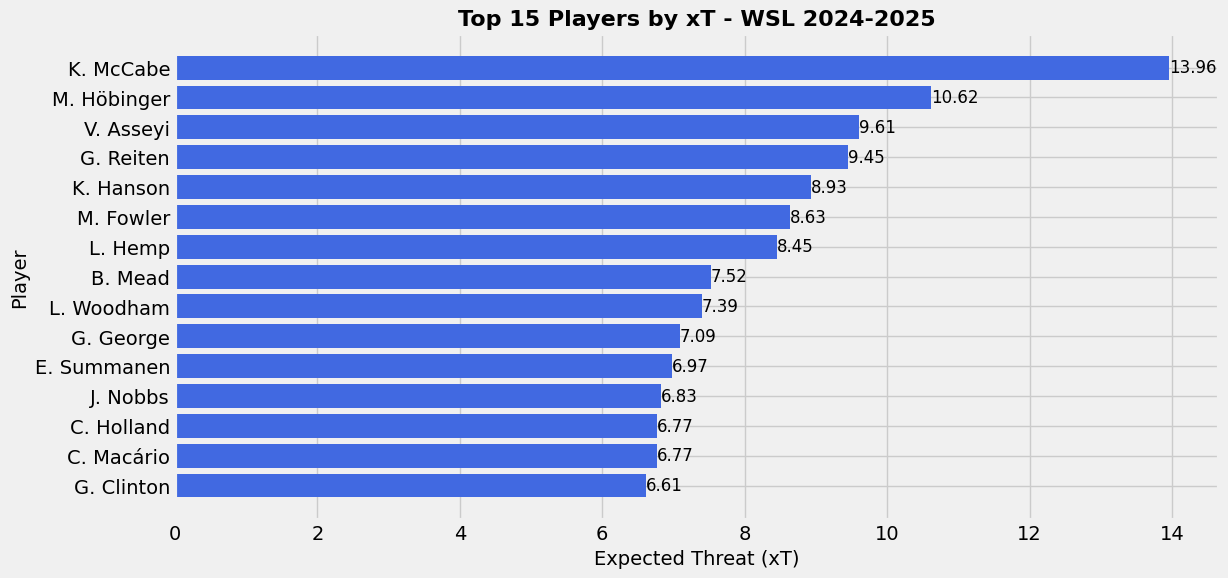

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Use FiveThirtyEight style
plt.style.use("fivethirtyeight")

# Load the Excel file
df = pd.read_excel("WSL xT.xlsx")

# Convert xT to numeric (just in case)
df['xT'] = pd.to_numeric(df['xT'], errors='coerce')

# Group by playerName and contestantId, summing xT
player_xT = df.groupby(['playerName', 'contestantId'])['xT'].sum().reset_index()

# Sort players by total xT and get top 15
top_players = player_xT.sort_values(by='xT', ascending=False).head(15)

# Plot bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(top_players['playerName'], top_players['xT'], color='royalblue')

# Add values next to bars
for bar in bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
            f"{bar.get_width():.2f}",  # Format to 2 decimal places
            va='center', ha='left', fontsize=12, color='black')

# Labels and title
ax.set_xlabel("Expected Threat (xT)", fontsize=14)
ax.set_ylabel("Player", fontsize=14)
ax.set_title("Top 15 Players by xT - WSL 2024-2025", fontsize=16, fontweight="bold")

# Flip to show highest at the top
ax.invert_yaxis()

# Show plot
plt.show()
